In [1]:
import os, shutil, itertools, yaml, kornia, torchvision, sys, copy, math
from functools import partial
import dill as pickle
from importlib import reload
osp = os.path
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
from PIL import Image
import torch
nn = torch.nn
F = nn.functional
import monai.transforms as mtr
from time import time

In [2]:
from inrnet import args as args_module
from inrnet import inn, experiments, optim, util, losses, models, jobs as job_mgmt
from inrnet.data import dataloader
from inrnet.experiments import depth
from inrnet.inn import qmc
import inrnet.inn.functional as inrF
from inrnet.models.inrs import siren, rff
%matplotlib inline
plt.rcParams["figure.figsize"] = (4.0, 3.0)
plt.rcParams['figure.dpi'] = 200

rescale_clip = mtr.ScaleIntensityRangePercentiles(lower=1, upper=99, b_min=0, b_max=255, clip=True, dtype=np.uint8)
rescale_noclip = mtr.ScaleIntensityRangePercentiles(lower=0, upper=100, b_min=0, b_max=255, clip=False, dtype=np.uint8)
rescale_float = mtr.ScaleIntensity()
DS_DIR = "/data/vision/polina/scratch/clintonw/datasets"
RESULTS_DIR = osp.expanduser("~/code/diffcoord/results")
TMP_DIR=osp.expanduser("~/code/diffcoord/temp")

In [8]:
import wandb

sweep_config = {
    "name": "lr sweep - imagenet",
    "method": "grid",
    "parameters": {
#         "data loading": {"parameters":{
#             "sample type": {
#                 "values": ["rqmc", "shrunk"],
#             }
#         }},
        "optimizer": {"parameters":{
            "learning_rate": {
                "values": [1e-5, 1e-4, 1e-3, 1e-2],
            }
        }}
    }
}
sweep_id = wandb.sweep(sweep_config, entity='clintonjwang', project='inrnet')

400 response executing GraphQL.
{"errors":[{"message":"Invalid sweep config: invalid hyperparameter configuration: optimizer","path":["upsertSweep"]}],"data":{"upsertSweep":null}}
wandb: ERROR Error while calling W&B API: Invalid sweep config: invalid hyperparameter configuration: optimizer (<Response [400]>)


CommError: Invalid sweep config: invalid hyperparameter configuration: optimizer

rsync -av --ignore-existing \
clintonw@peppercorn.csail.mit.edu:/data/vision/polina/users/clintonw/code/placenta/results/unetr_00 Downloads/

# interactive

### cmd line

In [ ]:
python train.py -c=seg_nn
bash train.sh seg_nn seg_nn
bash train.sh seg_cn seg_cn

bash train.sh seg_nn3 seg_nn3
bash train.sh seg_nn5 seg_nn5
bash train.sh seg_nn3f seg_nn3
bash train.sh seg_i3 seg_i3
bash train.sh seg_i3c seg_i3c
bash train.sh seg_i5 seg_i5
bash train.sh seg_i5c seg_i5c

bash train.sh seg_i3g seg_i3c
bash train.sh seg_i3q seg_i3q
bash train.sh seg_i3m seg_i3m

bash infer.sh sval_nn seg_valsm seg_nn
bash infer.sh sval_cn seg_valsm seg_cn

bash infer.sh seg_m2m seg_valm seg_i3m
bash infer.sh seg_q2m seg_valm seg_i3m
bash infer.sh seg_m2q seg_valq seg_i3m
bash infer.sh seg_q2q seg_valq seg_i3q
bash infer.sh seg_q2g seg_val_c seg_i3q
bash infer.sh seg_m2g seg_val_c seg_i3m
bash infer.sh seg_g2m seg_valm seg_i3g
bash infer.sh seg_g2q seg_valq seg_i3g
bash infer.sh seg_g2g seg_val_c seg_i3g
python infer.py -j=seg_g2q -c=seg_valq -t=seg_i3g

bash infer.sh scf_i3 seg_val seg_i3c
bash infer.sh scf_nn3 seg_val seg_nn3c
bash infer.sh scf_i5 seg_val seg_i5c
bash infer.sh scf_nn5 seg_val seg_nn5c
bash infer.sh sff_i3 seg_val seg_i3
bash infer.sh sff_nn3 seg_val seg_nn3
bash infer.sh sff_i5 seg_val seg_i5
bash infer.sh sff_nn5 seg_val seg_nn5
bash infer.sh scc_i3c seg_val_c seg_i3c
bash infer.sh scc_nn3c seg_val_c seg_nn3c
bash infer.sh scc_i5c seg_val_c seg_i5c
bash infer.sh scc_nn5c seg_val_c seg_nn5c

In [ ]:
bash train.sh inet_nn2 inet_nn2
bash train.sh inet_nn5 inet_nn5
bash train.sh inet_i2 inet_i2
bash train.sh inet_i5 inet_i5
bash train.sh inet_w2 inet_w2
bash train.sh inet_w5 inet_w5
bash train.sh inet_a2 inet_i2
bash train.sh inet_a5 inet_i5

bash train.sh inet_hid inet_hid
bash train.sh inet_i2g inet_i2g
bash train.sh inet_qmc inet_qmc

python infer.py -c=inet_val -t=inet_i5
bash infer.sh i1x_nn2 inet_val inet_nn2
bash infer.sh i2x_nn2 in2x_val inet_nn2
bash infer.sh i1x_nn5 inet_val inet_nn5
bash infer.sh i2x_nn5 in2x_val inet_nn5
bash infer.sh i1x_i2 inet_val inet_i2
bash infer.sh i2x_i2 in2x_val inet_i2
bash infer.sh i1x_i5 inet_val inet_i5
bash infer.sh i2x_i5 in2x_val inet_i5
bash infer.sh i1x_w2 inet_val inet_w2
bash infer.sh i2x_w2 in2x_val inet_w2
bash infer.sh i1x_w5 inet_val inet_w5
bash infer.sh i2x_w5 in2x_val inet_w5

bash infer.sh i1x_a2 inet_val inet_a2
bash infer.sh i2x_a2 in2x_val inet_a2
bash infer.sh i1x_a5 inet_val inet_a5
bash infer.sh i2x_a5 in2x_val inet_a5

bash infer.sh is_i2 ival_siren inet_i2
bash infer.sh is_w2 ival_siren inet_w2
bash infer.sh is_a2 ival_siren inet_a2
bash infer.sh is_nn2 ival_siren inet_nn2

In [ ]:
bash infer.sh grid_to_grid ival_grid inet_i2g
bash infer.sh grid_to_qmc inet_val inet_i2g

bash infer.sh hid_to_hid ival_hid inet_hid
bash infer.sh hid_to_qmc ival_qmc inet_hid
bash infer.sh qmc_to_hid ival_hid inet_qmc
bash infer.sh qmc_to_grid ival_grid inet_i2
bash infer.sh qmc_to_qmc ival_qmc inet_qmc
bash infer.sh qmc_to_rqmc inet_val inet_qmc
bash infer.sh qmc_to_grid ival_grid inet_qmc

In [ ]:
bash train.sh gen_nn4 gen_nn4
bash train.sh gen_i4 gen_i4

python infer.py -c=gen_val -t=gen_nn4
bash infer.sh gv_nn4 gen_val gen_nn4
bash infer.sh gv_i4 gen_val gen_i4

In [ ]:
bash train.sh warp_i3 warp_i3

In [ ]:
bash infer.sh benchmark inet_val inet_i5

### objectfolder

In [ ]:
python OF_render.py --modality vision \
      --object_file_path /data/vision/polina/scratch/clintonw/datasets/objectfolder/ObjectFolder1-100/1/ObjectFile.pth \
      --vision_test_file_path ~/code/ObjectFolder/demo/vision_1.npy \
      --vision_results_dir ~/code/ObjectFolder/results


In [265]:
x = torch.linspace(-1,1,16, dtype=torch.float, device='cuda')

In [ ]:
df['material'][0]

In [278]:
df = df[df['material'].isin(('Ceramic', 'Polycarbonate', 'Wood'))]

In [ ]:
for n in df.index:
    print(n)

In [ ]:
df = pd.read_csv(osp.expanduser('~/code/ObjectFolder/objects.csv'),
                 names=['id', 'name', 'volume', 'material', 'url'], index_col=0)

In [256]:
df = pd.read_csv(osp.expanduser('~/code/ObjectFolder/objects300.csv'), index_col=0)

In [255]:
df[:300].to_csv(osp.expanduser('~/code/ObjectFolder/objects300.csv'))

In [224]:
out = np.load(osp.expanduser('~/code/ObjectFolder/demo/vision_1.npy'))

In [ ]:
out

In [223]:
np.save(osp.expanduser('~/code/ObjectFolder/demo/vision_1.npy'), out[:1])

In [ ]:
bash train.sh gen_nn4 gen_nn4
bash train.sh gen_i4 gen_i4
python train.py -c=gen_nn4

In [ ]:
bash train.sh warp_inn warp_train
bash train.sh warp_nn warp_nn

### random fourier features

In [16]:
paths = util.glob2('/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/*/test_*.pt')
# for path in paths:
#     os.remove(path)

In [ ]:
path = '/data/vision/polina/scratch/clintonw/datasets/inrnet/cityscapes/fine_val_0.pt'
sd,seg = torch.load(path)
sinr = siren.Siren()
sinr.load_state_dict(sd)
sinr = siren.to_black_box([sinr])
img = sinr.cuda().produce_images(256,256)

In [33]:
path = '/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/6/val_4.pt'
sd = torch.load(path)
sinr = siren.Siren()
sinr.load_state_dict(sd)
sinr = siren.to_black_box([sinr])
img = sinr.cuda().produce_images(256,256)

In [35]:
path = '/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/6/test_4.pt'
sd = torch.load(path)
inr = rff.RFFNet()
inr.load_state_dict(sd)
inr = rff.to_black_box([inr])
img2 = inr.cuda().produce_images(256,256)

In [ ]:
import imgviz
labelviz_pred = imgviz.label2rgb(seg.max(0).indices)
plt.imshow(labelviz_pred); plt.axis('off')

In [ ]:
util.imshow(img)

In [ ]:
util.imshow(torch.cat(((img+1)/2, img2), dim=-1))

In [163]:
m = torchvision.models.resnet18(pretrained=False)

### audio

In [92]:
df = pd.read_csv(f'{DS_DIR}/environmental-sound-classification/esc50.csv')
classes = np.array(df[['target', 'category']]).tolist()
classes = set(['{} {}'.format(c[0], c[1]) for c in classes])
classes = np.array([c.split(' ') for c in classes])
classes = {k: v for k, v in classes}

In [ ]:
classes

In [95]:
from inrnet.data.audio import utils
ESC50 = utils.ESC50

In [ ]:
train_splits = [1,2,3,4]
test_split = 5

shared_params = {'csv_path': f'{DS_DIR}/environmental-sound-classification/esc50.csv',
                 'wav_dir': f'{DS_DIR}/environmental-sound-classification/audio',
                 'dest_dir': f'{DS_DIR}/environmental-sound-classification/16000',
                 'audio_rate': 16000,
                 'only_ESC10': True,
                 'pad': 0,
                 'normalize': True}

train_gen = ESC50(folds=train_splits,
                  randomize=True,
                  strongAugment=True,
                  random_crop=True,
                  inputLength=2,
                  mix=True,
                  **shared_params).batch_gen(16)

test_gen = ESC50(folds=[test_split],
                 randomize=False,
                 strongAugment=False,
                 random_crop=False,
                 inputLength=4,
                 mix=False,
                 **shared_params).batch_gen(16)

X, Y = next(train_gen)

### swin

In [156]:
sd = torch.load('/data/vision/polina/users/clintonw/code/diffcoord/temp/upernet_deit.pth')['state_dict']

In [158]:
sd['backbone.patch_embed.projection.weight'].shape

torch.Size([384, 3, 16, 16])

In [157]:
sd.keys()

odict_keys(['backbone.cls_token', 'backbone.pos_embed', 'backbone.patch_embed.projection.weight', 'backbone.patch_embed.projection.bias', 'backbone.layers.0.ln1.weight', 'backbone.layers.0.ln1.bias', 'backbone.layers.0.attn.attn.in_proj_weight', 'backbone.layers.0.attn.attn.in_proj_bias', 'backbone.layers.0.attn.attn.out_proj.weight', 'backbone.layers.0.attn.attn.out_proj.bias', 'backbone.layers.0.ln2.weight', 'backbone.layers.0.ln2.bias', 'backbone.layers.0.ffn.layers.0.0.weight', 'backbone.layers.0.ffn.layers.0.0.bias', 'backbone.layers.0.ffn.layers.1.weight', 'backbone.layers.0.ffn.layers.1.bias', 'backbone.layers.1.ln1.weight', 'backbone.layers.1.ln1.bias', 'backbone.layers.1.attn.attn.in_proj_weight', 'backbone.layers.1.attn.attn.in_proj_bias', 'backbone.layers.1.attn.attn.out_proj.weight', 'backbone.layers.1.attn.attn.out_proj.bias', 'backbone.layers.1.ln2.weight', 'backbone.layers.1.ln2.bias', 'backbone.layers.1.ffn.layers.0.0.weight', 'backbone.layers.1.ffn.layers.0.0.bias', 'b

### fashionMNIST

In [36]:
ds = torchvision.datasets.FashionMNIST(root=DS_DIR, train=True)#, transform=transforms.ToTensor())
len(ds)
#inr = siren.Siren(out_channels=1, C=64, first_omega_0=20, hidden_omega_0=20)
# xy = util.meshgrid_coords(28,28, c2f=False)
# r = xy.norm(dim=-1)
# torch.sin(theta)
# maxr_theta = min()
# theta = torch.atan2(xy[:,1], xy[:,0])
# theta.max()
# plt.imshow(ds[0][0][0], cmap='gray')

60000

In [ ]:
paths = [f"{DS_DIR}/inrnet/fmnist/train_{ix}.pt" for ix in range(60000)]
paths = [p for p in paths if osp.exists(p)]

In [48]:
for p in paths:
    x = osp.basename(p)[:-3]
    x = x[x.find('_')+1:]
    ix = int(x)
    ix_to_cls[ix] = torch.load(p)[1]
    break

In [39]:
torch.save(ix_to_cls, f"{DS_DIR}/inrnet/fmnist/ix_to_cls.pt")

### warp

In [175]:
subset='train'
paths = util.glob2(f"{DS_DIR}/inrnet/oasis/{subset}_*_0.pt")

In [ ]:
torch.load(paths[0])[0]['net.4.weight'].shape

In [ ]:
labels = open('/data/vision/polina/scratch/clintonw/datasets/oasis/seg4_labels.txt', 'r')
labels.readlines()

orig_img /= orig_img.max()
orig_seg = (seg==3).float()
vf2df = DVF2DDF()
warp = Warp()
VFs = F.interpolate(torch.randn(3,2,H//16,W//16), scale_factor=16)*2 + \
      F.interpolate(torch.randn(3,2,H//8,W//8), scale_factor=8) + \
      F.interpolate(torch.randn(3,2,H//4,W//4), scale_factor=4)/2
VFs[1:2] = VFs[:1]+VFs[1:2]
VFs[2:3] = VFs[1:2]+VFs[2:3]
w1 = warp(orig_img, vf2df(VFs[:1]))
w2 = warp(orig_img, vf2df(VFs[1:2]))
w3 = warp(orig_img, vf2df(VFs[2:3]))
s1 = warp(orig_seg, vf2df(VFs[:1]))
s2 = warp(orig_seg, vf2df(VFs[1:2]))
s3 = warp(orig_seg, vf2df(VFs[2:3]))
segs = (orig_seg.bool(), s1>.5, s2>.5, s3>.5)

plt.imshow(s3.squeeze())

### etc

In [215]:
sd = torch.load('/data/vision/polina/users/clintonw/code/diffcoord/temp/wgan.pth')['state_dict']

In [181]:
base = torchvision.models.efficientnet_b0(pretrained=False, device='cuda')
optim = torch.optim.Adam(base.parameters())
optim.zero_grad()

In [ ]:
CUDA_VISIBLE_DEVICES=3 python train.py -j=inet2 -c=inet

In [6]:

from inrnet.models.common import Conv2, Conv5
from inrnet.inn.nets.effnet import InrCls2, InrCls4, InrClsWide2, InrClsWide4

In [ ]:
kwargs = dict(in_channels=3, out_dims=12)
for m in (Conv2, Conv5, InrCls2, InrClsWide2, InrCls4, InrClsWide4):
    print(count_parameters(m(**kwargs)))

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [97]:
base = torch.load(osp.expanduser('~/code/diffcoord/temp/upernet_convnext.pth'))

In [203]:
img = plt.imread('/data/vision/polina/scratch/clintonw/datasets/cityscapes/gtCoarse/val/frankfurt/frankfurt_000001_080091_gtCoarse_labelIds.png')

In [ ]:
base = torchvision.models.efficientnet_b0(pretrained=True)
base

In [42]:
DS_DIR = "/data/vision/polina/scratch/clintonw/datasets"
ds = torchvision.datasets.CIFAR10(root=DS_DIR, transform=transforms.ToTensor())

In [78]:
torch.cuda.empty_cache()
coords = util.meshgrid_coords(64,64)
#spacing = torch.tensor((4/127,4/127), device="cuda")
values = torch.randn(coords.size(0),6, device=coords.device)

In [2]:
## search python strings
import os
osp = os.path
root = osp.expanduser("~/code/inrnet/inrnet")
query_string = "dropping l"
for folder, subfolders, files in os.walk(root):
    for file in files:
        if file.endswith(".py"):
            path = osp.join(folder, file)
            with open(path, 'r') as f:
                if query_string in f.read():
                    print(path)

/data/vision/polina/users/clintonw/code/inrnet/inrnet/data/cityscapes.py
/data/vision/polina/users/clintonw/code/inrnet/inrnet/data/inet.py


### sympy

In [151]:
from sympy import sin, cos, tan, exp, log, integrate
from sympy.abc import a,b,c,n,m,x,y
from sympy import Point, Polygon
from sympy.integrals.intpoly import polytope_integrate

In [149]:
from sympy.functions.special import polynomials, spherical_harmonics

In [173]:
function = (3*polynomials.legendre(2, x)-2*polynomials.legendre(1, x) - 1) * \
    (.6*polynomials.legendre(4, y)-polynomials.legendre(1, y)+1.1)

In [ ]:
function

In [162]:
polygon = Polygon(Point(0, 0), Point(0, 1), Point(1, 1), Point(1, 0))
# polys = [1, x, y, x*y, x**2*y, x*y**2]
# expr = x*y

In [174]:
polytope_integrate(polygon, expr=function)

nan

In [146]:
polytope_integrate(polygon, expr=expr)

1/4

In [147]:
polytope_integrate(polygon, polys, max_degree=3)

{1: 1, x: 1/2, y: 1/2, x*y: 1/4, x**2*y: 1/6, x*y**2: 1/6}

### inet12

In [3]:
from inrnet.models.inrs import siren
keys = siren.get_siren_keys()

In [12]:
from robustness.tools.imagenet_helpers import ImageNetHierarchy, common_superclass_wnid
in_path = '/data/vision/polina/scratch/clintonw/datasets/imagenet_pytorch'
in_hier = ImageNetHierarchy(in_path, in_path)
superclass_wnid = common_superclass_wnid('big_12')
class_ranges, label_map = in_hier.get_subclasses(superclass_wnid,
                                                 balanced=True)

In [10]:
subpaths = open("/data/vision/polina/scratch/clintonw/datasets/imagenet_pytorch/train.txt",
            "r").read().split('\n')
labels = open("/data/vision/polina/scratch/clintonw/datasets/imagenet_pytorch/labels.txt",
            "r").read().split('\n')
labels = [l[:l.find(',')] for l in labels[:-1]]
class_labels = [np.array(labels)[list(cr)].tolist() for cr in class_ranges]

In [ ]:
sub_to_super = {}
for supercls,subclasses in enumerate(class_ranges):
    for subcls in subclasses:
        sub_to_super[subcls] = supercls

# big12path = f"{DS_DIR}/inrnet/big_12.pkl"
# pickle.dump((label_map, class_ranges, sub_to_super), open(big12path, 'wb'))
# label_map, class_ranges, sub_to_super = pickle.load(open(big12path, 'rb'))

In [ ]:
label_to_super = {}
for supercls,subclasses in enumerate(class_labels):
    for subcls in subclasses:
        label_to_super[subcls] = supercls

In [ ]:
N = 800
subpaths_by_cls = [[] for _ in range(12)]
for path in subpaths:
    label = osp.basename(osp.dirname(path))
    if label in label_to_super.keys():
        subpaths_by_cls[label_to_super[label]].append(path)

for p in subpaths_by_cls:
    np.random.shuffle(p)

split_paths_by_cls = {'train':[p[:N] for p in subpaths_by_cls],
                     'test':[p[N:] for p in subpaths_by_cls]}

# big12path = f"{DS_DIR}/inrnet/big_12_labels.pkl"
# pickle.dump((split_paths_by_cls, class_labels, label_to_super), open(big12path, 'wb'))
# split_paths_by_cls, class_labels, label_to_super = pickle.load(open(big12path, 'rb'))

In [19]:
subpaths_by_cls = [[] for _ in range(12)]
for path in subpaths:
    label = osp.basename(osp.dirname(path))
    if label in label_to_super.keys():
        subpaths_by_cls[label_to_super[label]].append(path)

for p in subpaths_by_cls:
    np.random.shuffle(p)

In [26]:
N = 23400
subpaths_by_cls = [p[:N] for p in subpaths_by_cls]

In [27]:
big12path = f"{DS_DIR}/inrnet/big_12_extra.pkl"
pickle.dump(subpaths_by_cls, open(big12path, 'wb'))
# subpaths_by_cls = pickle.load(open(big12path, 'rb'))

In [ ]:
paths = util.glob2('/data/vision/polina/scratch/clintonw/datasets/inrnet/cityscapes/train_*.pt')
for p in paths:
    weights, seg = torch.load(p)
    break

# Tables

### Classify

In [80]:
model_jobs = {
#     '2-layer CNN':('i1x_nn2200', 'i2x_nn2200'),
#     'Grid$\\to$Grid':('grid_to_grid',),
#     'Grid$\\to$QMC':('grid_to_qmc',),
#     'QMC$\\to$Grid':('qmc_to_grid',),
#     'QMC$\\to$QMC':('qmc_to_rqmc',),
#     'QMC$\\to$Shrunk':('qmc_to_hid',),
#     'Shrunk$\\to$QMC':('hid_to_qmc',),
#     'Shrunk$\\to$Shrunk':('hid_to_hid',),
#     '2-layer CNN':('i1x_nn2', 'i2x_nn2'),
#     '4-layer CNN':('i1x_nn5', 'i2x_nn5'),
#     f'\modelname-2 (ours)':('i1x_i2', 'i2x_i2'),
#     f'\modelname-5 (ours)':('i1x_i5', 'i2x_i5'),
    
    'val set (SIRENs)':('is_i2','is_w2','is_a2','is_nn2'),
    
#     f'\modelname-w2 (ours)':('i1x_w2', 'i2x_w2'),
#     f'\modelname-w5 (ours)':('i1x_w5', 'i2x_w5'),
    
#     f'\modelname-a2 (ours)':('i1x_a2', 'i2x_a2'),
#     f'\modelname-a5 (ours)':('i1x_a5', 'i2x_a5'),
    
#     '2-layer CNN1k':('i1x_nn21k', 'i2x_nn21k'),
#     f'\modelname-2 (ours)1k':('i1x_i21k', 'i2x_i21k'),
#     '4-layer CNN1k':('i1x_nn51k', 'i2x_nn51k'),
#     f'\modelname-5 (ours)1k':('i1x_i51k', 'i2x_i51k'),
    
#     'EfficientNet \cite{efficientnet}':('i1x_nn', 'i2x_nn'),
#     'INR-ft (ours)':('i1x_inn', 'i2x_inn'),
#     'INR-mlp (ours)':('i1x_mlp', 'i2x_mlp'),
}
N = 200*12
for model,row in model_jobs.items():
    rowstr = [model]
    for job in row:
        path = osp.join(RESULTS_DIR, job, "stats.pt")
        if not osp.exists(path):
            print(f'missing {job} results at {path}')
            rowstr.append("nan")
        else:
            top1, top3 = torch.load(path)
            rowstr.append(util.format_float(top3/N*100, n_decimals=1)+r"\%")
    print(' & '.join(map(str,rowstr)) + r' \\')
#     if model.endswith('ours)'):
#         print(r'\hline')

missing is_a2 results at /data/vision/polina/users/clintonw/code/diffcoord/results/is_a2/stats.pt
missing is_nn2 results at /data/vision/polina/users/clintonw/code/diffcoord/results/is_nn2/stats.pt
val set (SIRENs) & 54.0\% & 55.0\% & nan & nan \\


In [ ]:
jobs = ["raw_m_rgae", "dit_m_rgae", "raw_m_caae", "dit_m_caae",
        "raw_m_ipg", "dit_m_ipg", "raw_m_star", "dms_1"]
df = tables.get_results_table()
subtable = df.loc[jobs]

def latex_format(value, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$'%n_decimals).format(value)        
    else:
        return (r'${0:.%df}$'%n_decimals).format(value)
def plus_minus_format(mean, std, n_decimals=2, bold=False):
    if bold:
        return (r'$\bm{{{0:.%df}}}$\scriptsize$\bm{{\pm {1:.%df}}}$'%(n_decimals, n_decimals)).format(mean, std)        
    else:
        return (r'${0:.%df}$\scriptsize$\pm {1:.%df}$'%(n_decimals, n_decimals)).format(mean, std)

def print_row(name, row, bold=()):
    field1 = latex_format(row["FID_tuned"], bold=1 in bold)
    field2 = latex_format(row["F_{1/8}"], bold=2 in bold)
    field3 = latex_format(row["F_8"], bold=3 in bold)
    field4 = plus_minus_format(row["age mean error"], row["age error STD"], bold=4 in bold)
    print(" & ".join([name, field1, field2, field3, field4]) + r" \\")

### Segment

In [75]:
model_jobs = {
#     'CNN-3':('scc_nn3c','scf_nn3',), #sff_nn3
#     'INR-3 (ours)':('scc_i3c','scf_i3'),
#     'CNN-5':('scc_nn5c','scf_nn5',),
#     'INR-5 (ours)':('scc_i5c','scf_i5',),

#     'Grid$\\to$QMC':['seg_g2q'],
#     'Grid$\\to$Grid':['seg_g2g'],
#     'QMC$\\to$Grid':['seg_q2g'],
#     'QMC$\\to$QMC':['seg_q2q'],
#     'Mask$\\to$Mask':['seg_m2m'],
#     'Mask$\\to$QMC':['seg_m2q'],
#     'Mask$\\to$Grid':['seg_m2g'],
#     'QMC$\\to$Mask':['seg_q2m'],
#     'Grid$\\to$Mask':['seg_g2m'],
    
    'ConvNexT':['sval_nn'],
    'INR-tuned':['sval_cn'],#['sval_cn'],
}
for model,row in model_jobs.items():
    rowstr = [model]
    for job in row:
        path = osp.join(RESULTS_DIR, job, "stats.pt")
        if not osp.exists(path):
            print(f'missing {job} results at {path}')
            rowstr.append("nan")
        else:
            iou, acc = torch.load(path)
            rowstr.append(util.format_float(np.nanmean(iou), n_decimals=3))
            rowstr.append(util.format_float(np.mean(acc)*100, n_decimals=1)+r"\%")
    print(' & '.join(map(str,rowstr)) + r' \\')
#     if model.endswith('ours)'):
#         print(r'\hline')

ConvNexT & 0.429 & 68.1\% \\
INR-tuned & 0.376 & 68.7\% \\


### Generate

In [ ]:
model_jobs = {'EffNet-T':('f1x_nn', 'f2x_nn', 'fhx_nn'),
    'INR-tuned (ours)':('f1x_inn', 'f2x_inn', 'fhx_inn'),
    'INR-scratch (ours)':('f1x_scr', 'f2x_scr', 'fhx_scr')}
N = 200*12
for model,row in model_jobs.items():
    rowstr = [model]
    for job in row:
        path = osp.join(RESULTS_DIR, job, "stats.pt")
        if not osp.exists(path):
            print(f'missing {job} results at {path}')
            rowstr.append("nan")
        else:
            top1, top3 = torch.load(path)
            rowstr.append(util.format_float(top3/N*100, n_decimals=1)+r"\%")
    print(' & '.join(map(str,rowstr)) + r' \\')

# Figs

## for framework

In [9]:
from scipy.stats import qmc as sqmc

In [ ]:
sampler = sqmc.Sobol(d=2, scramble=True)
xy = sampler.random_base2(m=int(math.log2(256)))
plt.rcParams["figure.figsize"] = (1,1)
fig,ax = plt.subplots()
ax.scatter(xy[:,0], xy[:,1], s=2, c='k')
ax.plot();
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([]);

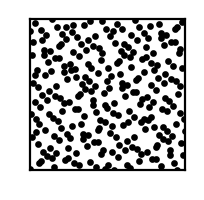

In [48]:
sampler = sqmc.Halton(d=2, scramble=True)
xy = sampler.random(n=256)
plt.rcParams["figure.figsize"] = (1,1)
fig,ax = plt.subplots()
ax.scatter(xy[:,0], xy[:,1], s=2, c='k')
ax.plot();
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([]);

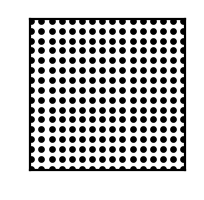

In [44]:
xy = np.stack(np.meshgrid(np.linspace(.01, .99, 16), np.linspace(.01, .99, 16))).transpose().reshape(-1,2)
plt.rcParams["figure.figsize"] = (1,1)
fig,ax = plt.subplots()
ax.scatter(xy[:,0], xy[:,1], s=2, c='k')
ax.plot();
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([]);

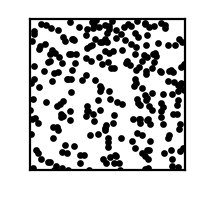

In [45]:
xy = np.random.rand(256,2)
plt.rcParams["figure.figsize"] = (1,1)
fig,ax = plt.subplots()
ax.scatter(xy[:,0], xy[:,1], s=2, c='k')
ax.plot();
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([]);

In [ ]:
xy = qmc.generate_quasirandom_sequence(d=2, n=256, scramble=True)
plt.rcParams["figure.figsize"] = (1,1)
fig,ax = plt.subplots()
ax.scatter(xy[:,0], xy[:,1], s=2, c='k')
ax.plot();

coords = gen_inr.parent(10).sampled_coords
fig,ax = plt.subplots()
ax.scatter(coords[:,0].cpu().numpy(), coords[:,1].cpu().numpy(), s=2, c='k')
ax.plot();
path = paths["job output dir"]+f"/imgs/{global_step}.png"
plt.savefig(path)

In [ ]:
kernel = model.features[0][0].weight[3,1].detach()
plt.rcParams["figure.figsize"] = (.5,.5)
fig,ax = plt.subplots()
print(kernel.min().item(), kernel.max().item())
ax.imshow(kernel, vmin=-2.9, vmax=2.9);
plt.axis('off');

In [100]:
from scipy.interpolate import RectBivariateSpline as Spline2D
K = [2.5,2.5]
h,w=3,3
bbox = (-K[0]/2, K[0]/2, -K[1]/2, K[1]/2)
x,y = (np.linspace(bbox[0]/h*(h-1), bbox[1]/h*(h-1), h),
       np.linspace(bbox[2]/w*(w-1), bbox[3]/w*(w-1), w))
bs = Spline2D(x,y, kernel, bbox=bbox, kx=2,ky=2, s=0)
tx,ty,c = [torch.tensor(z).float() for z in bs.tck]
c = c.reshape(h,w)

In [106]:
H = 50
xy = util.meshgrid_coords(H,H).cpu()
w_oi = []
X = xy[:,0].unsqueeze(1)
Y = xy[:,1].unsqueeze(1)
px = py = 2

values, kx = (tx<=X).min(dim=-1)
values, ky = (ty<=Y).min(dim=-1)
kx -= 1
ky -= 1
kx[values] = tx.size(-1)-px-2
ky[values] = ty.size(-1)-py-2

Ctrl = c.view(1, *c.shape[-2:])
for z in range(X.size(0)):
    D = Ctrl[:, kx[z]-px : kx[z]+1, ky[z]-py : ky[z]+1].clone()

    for r in range(1, px + 1):
        try:
            alphax = (X[z,0] - tx[kx[z]-px+1:kx[z]+1]) / (
                tx[2+kx[z]-r:2+kx[z]-r+px] - tx[kx[z]-px+1:kx[z]+1])
        except RuntimeError:
            print("input off the grid")
        for j in range(px, r - 1, -1):
            D[:,j] = (1-alphax[j-1]) * D[:,j-1] + alphax[j-1] * D[:,j].clone()

    for r in range(1, py + 1):
        alphay = (Y[z,0] - ty[ky[z]-py+1:ky[z]+1]) / (
            ty[2+ky[z]-r:2+ky[z]-r+py] - ty[ky[z]-py+1:ky[z]+1])
        for j in range(py, r-1, -1):
            D[:,px,j] = (1-alphay[j-1]) * D[:,px,j-1].clone() + alphay[j-1] * D[:,px,j].clone()

    w_oi.append(D[:,px,py])

w = torch.stack(w_oi).view(xy.size(0))

In [107]:
k = w.reshape(H,H)

In [ ]:
fig,ax = plt.subplots()
print(k.min().item(), k.max().item())
ax.imshow(k, vmin=-2.9, vmax=2.9);
plt.axis('off');

## analysis

In [ ]:
from inrnet.experiments import classify
classify.analyze_change_resolution_grid_vs_qmc()

In [ ]:
ax = sns.lineplot(x=torch.linspace(128,256,10), y=torch.linspace(.5,.8,10)+torch.randn(10)/8, label="qmc");
sns.lineplot(x=torch.linspace(128,256,10), y=torch.linspace(.1,.8,10)+torch.randn(10)/8, label="grid", ax=ax);
ax.set_xlabel("Number of sample points");
ax.set_ylabel("ImageNet top-1 error");

### Deviation over depth

### Resolution vs. output (grid & QMC)

In [42]:
base_logits, grid_logits, grid_masks, qmc_logits, qmc_masks = torch.load(osp.expanduser(
    '~/code/diffcoord/temp/change_resolution_grid_vs_qmc.pt'))

In [43]:
grid_dists = (torch.cat(grid_logits, dim=0) - base_logits.cpu()).norm(dim=-1)
qmc_dists = (torch.cat(qmc_logits, dim=0) - base_logits.cpu()).norm(dim=-1)

In [46]:
RES = np.round(np.logspace(4, 8, num=9, base=2)).astype(int)

In [ ]:
plt.rcParams["figure.figsize"] = (2.0, 1.5)
x = np.arange(7)
plt.plot(x,qmc_dists[1:], label='qmc');
plt.plot(x,grid_dists[1:], label='grid');
plt.xticks(ticks=[1,3,5],labels=(32,64,128))
plt.yticks([]);
# plt.legend()

In [ ]:
grid_dists

In [ ]:
torch.sort(base_logits[0]).indices

In [ ]:
torch.sort(qmc_logits[-1][0]).indices

In [ ]:
plt.bar(grid_dists)

In [208]:
front_g_m = torch.stack([m[0].float().mean() for m in grid_masks], dim=0)
front_g_s = torch.stack([m[0].float().std() for m in grid_masks], dim=0)
back_g_m = torch.stack([m[1].float().mean() for m in grid_masks], dim=0)
back_g_s = torch.stack([m[1].float().std() for m in grid_masks], dim=0)

In [ ]:
front_g_m, front_g_s

In [ ]:
back_g_m, back_g_s

In [185]:
front_q_m = torch.stack([m[0].float().mean() for m in qmc_masks], dim=0)
front_q_s = torch.stack([m[0].float().std() for m in qmc_masks], dim=0)
back_q_m = torch.stack([m[1].float().mean() for m in qmc_masks], dim=0)
back_q_s = torch.stack([m[1].float().std() for m in qmc_masks], dim=0)

In [ ]:
front_q_m, front_q_s

In [ ]:
back_q_m, back_q_s

### RQMC variance

In [37]:
base_logits, logits, masks = torch.load(osp.expanduser('~/code/diffcoord/temp/output_variance_rqmc.pt'))

In [38]:
logit_dists = (torch.cat(logits, dim=0) - base_logits.cpu()).norm(dim=-1)

In [ ]:
base_logits

In [ ]:
logit_dists

In [ ]:
fronts = torch.stack([m[0] for m in masks], dim=0).float()
backs = torch.stack([m[1] for m in masks], dim=0).float()

In [ ]:
fronts.mean(1), fronts.std(1), fronts.amin(1), fronts.amax(1)

In [ ]:
backs.mean(1), backs.std(1), backs.amin(1), backs.amax(1)

### grid-QMC interpolation

In [ ]:
base_logits, grid_logits, grid_mask, qmc_logits, qmc_mask, intermediate_logits, intermediate_masks = torch.load(osp.expanduser('~/code/diffcoord/temp/analyze_logit_mismatch.pt'))

x = np.arange(0,1.01,.05)
fronts = torch.stack([grid_mask[0], *[m[0] for m in intermediate_masks[::-1]], qmc_mask[0]], dim=0).float()
backs = torch.stack([grid_mask[1], *[m[1] for m in intermediate_masks[::-1]], qmc_mask[1]], dim=0).float()
f_m, f_s = fronts.mean(1), fronts.std(1)
b_m, b_s = backs.mean(1), backs.std(1)

fig,ax = plt.subplots()
width = .007
ax.errorbar(x-width/2, f_m, yerr=f_s, label='front')
ax.errorbar(x+width/2, b_m, yerr=b_s, label='back')

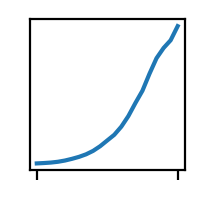

In [211]:
y = (torch.cat([grid_logits, *intermediate_logits[::-1], qmc_logits], dim=0) - base_logits.cpu()).norm(dim=1)
plt.plot(x,y);
plt.xticks(ticks=[0,1],labels=('',''))
plt.yticks([]);

# slurm

In [45]:
coco_len = 118287
kitti_len = 80896
horse_len = 1067
zebra_len = 1334
inet_len = 50000
in_tr_len = 50000

In [ ]:
configs/convnext/upernet_convnext_tiny
configs/_base_/models/upernet_convnext.py

In [ ]:
for ix in range(0,places_len,800):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/places/siren_{ix+63}.pt"):
        print("sh fit_inr.sh", f"place{ix//800}", "fit_places", ix)

In [ ]:
for ix in range(0,in_tr_len,800):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/imagenet1k_train/siren_{ix+63}.pt"):
        print("sh fit_inr.sh", f"inet{ix//800}", "fit_in_tr", ix)

In [ ]:
for ix in range(0,60000,5000):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/fmnist/train_{ix+1}.pt"):
        print("sh fit_inr.sh", f"fmn{ix//5000}", "fit_fmnist", ix)

In [ ]:
for ix in range(0,12000,100):
    c,i=ix//1000, ix%1000
    if i >= 800:
        i-=800
        s='val'
    else:
        s='train'
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/{c}/{s}_{i+3}.pt"):
        print("sh fit_inr.sh", f"inet{ix//100}", "fit_i12", ix)

In [35]:
for ix in range(0,2400,50):
    c,i = ix%12, ix//12
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/{c}/test_{i+1}.pt"):
        print("sh fit_inr.sh", f"rff{ix//50}", "fit_in_rff", ix)

In [ ]:
#23400 * 12 = 280800 total images
#15000/12 + 800 = 2050 current images per class
for ix in range(36000,48000,100):
    cls, start_ix = ix % 12, ix // 12 + 800
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/{cls}/train_{start_ix+4}.pt"):
        print("sh fit_inr.sh", f"inet{ix//100}", "fit_i12", ix)

In [ ]:
for ix in range(0,8189,100):
    i = ix
    if i < 1020:
        s='train'
    elif i < 2040:
        s='val'
        i -= 1020
    else:
        s='test'
        i -= 2040
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/flowers/{s}_{i+50}.pt"):
        print("sh fit_inr.sh", f"flow{ix//100}", "fit_flower", ix)

In [ ]:
for ix in range(3475,4475,100):
    i = ix
    if i >= 2975:
        i -= 2975
        s = 'val'
    else:
        s = 'train'
        i -= 500
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/cityscapes/{s}_{i+1}.pt"):
        print("sh fit_inr.sh", f"city{ix//100}", "fit_city", ix)

In [46]:
for ix in range(0,inet_len,800):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/imagenet1k_val/siren_{ix+63}.pt"):
        print("sh fit_inr.sh", f"inet{ix//800}", "fit_inet", ix)

In [37]:
x[0,0] = 1

In [ ]:
for ix in range(0,coco_len,1600):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/coco/siren_{ix+63}.pt"):
        print("sh fit_inr.sh", f"coco{ix//1600}", "fit_coco", ix)

In [ ]:
for ix in range(0,kitti_len,800):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/kitti/siren_{ix+63}.pt"):
        print("sh fit_inr.sh", f"skit{ix//800}", "fit_kitti", ix)

In [ ]:
for ix in range(0,zebra_len,128):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/zebra/siren_{ix+15}.pt"):
        print("sh fit_inr.sh", f"zebra{ix//128}", "fit_zebra", ix)

In [ ]:
for ix in range(0,horse_len,128):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/horse/siren_{ix+15}.pt"):
        print("sh fit_inr.sh", f"horse{ix//128}", "fit_horse", ix)

In [ ]:
for ix in range(0,10000,5000):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/cifar10_test/siren_{ix+999}.pt"):
        print("sh fit_inr.sh", f"cit{ix//5000}", "fit_ciftest", ix)
for ix in range(0,50000,5000):
    if not osp.exists(f"/data/vision/polina/scratch/clintonw/datasets/inrnet/cifar10_train/siren_{ix+999}.pt"):
        print("sh fit_inr.sh", f"cif{ix//5000}", "fit_cifar", ix)

In [ ]:
img = plt.imread("/data/vision/polina/scratch/clintonw/datasets/inrnet/horse2zebra/testA/n02381460_9260.jpg")

In [ ]:
"/data/vision/polina/scratch/clintonw/datasets/coco/annotations/panoptic_train2017"

In [ ]:
osp.exists(f"/data/vision/polina/users/clintonw/code/diffcoord/temp/kitti/siren_{ix+63}.pt")

In [60]:
paths = util.glob2("/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/1/loss_*")

In [21]:
paths = util.glob2("/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/0/loss_train_*")
losses = []
for p in paths:
    losses.append(float((open(p,'r').read())))

In [17]:
paths = [f"/data/vision/polina/scratch/clintonw/datasets/inrnet/inet12/0/loss_test_{ix}.txt" for ix in range(800)]
losses = []
for p in paths:
    losses.append(float((open(p,'r').read())))

In [28]:
paths = [f"/data/vision/polina/scratch/clintonw/datasets/inrnet/cityscapes/loss_train_{ix}.txt" for ix in range(800)]
losses = []
for p in paths:
    losses.append(float((open(p,'r').read())))

In [32]:
np.mean(losses)*1e4

3.642220564870513